# Linear regression with genomic data

this is the companion colab code for my tutorial in medium about **Linear regression with genomic data** in Python, please read the article for better understanding of the code. In the article I discuss about the theory, the hyperparameters, how to efficiently use the techniques. Here I am providing just generic information about the algorithm and the code. 
this is a colab notebook, you can test in colab (all the code has been tested and you do not need to set your machine)

[Medium article](https://medium.com/leukemiaairesearch/a-complete-guide-to-linear-regression-using-gene-expression-data-fit-and-algorithm-evaluation-d73e39b2eb8f)

for other stories check my medium profile:
[Salvatore Raieli](https://salvatore-raieli.medium.com/)

## Preparing the dataset

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
#import necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

#dataset
data = pd.read_table("/content/gdrive/My Drive/aml/201028_GSE122505_Leukemia_clean.txt", sep = "\t")
#table of the disease
data.disease.value_counts()

AML                                         969
ALL                                         906
Infection                                   113
CLL                                          85
healthy                                      82
Diabetes_Type_I                              74
AMKL                                         63
Diabetes_Type_II                             29
CML                                          22
clinically_isolated_syndrome                 18
MDS                                          10
DS_transient_myeloproliferative_disorder      8
Name: disease, dtype: int64

In [ ]:
#removing some disease type
data["disease"] = np.where(data["disease"] == "Diabetes_Type_I" , "Diabetes", data["disease"])
data["disease"] = np.where(data["disease"] == "Diabetes_Type_II" , "Diabetes", data["disease"])
other = ['CML','clinically_isolated_syndrome', 'MDS', 'DS_transient_myeloproliferative_disorder']
data = data[~data.disease.isin(other)]


In [ ]:
selected = ['AML','ALL']
data = data[data.disease.isin(selected)]
data.disease.value_counts()


AML    969
ALL    906
Name: disease, dtype: int64

In [ ]:
target = data["disease"]
df = data.drop("disease", 1)
df = df.drop("GSM", 1)
df = df.drop("FAB", 1)
df.shape
df = df.drop(df.var()[(df.var() < 0.3)].index, axis=1)
from scipy.stats import zscore
df = df.apply(zscore)
df.shape


(1875, 4252)

In [ ]:
data.disease.value_counts()

AML    969
ALL    906
Name: disease, dtype: int64

##Fitting the model

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#inputs and dependent variable
X = df.drop("MYC", 1)
y = df["MYC"]
#dividing in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

No handles with labels found to put in legend.


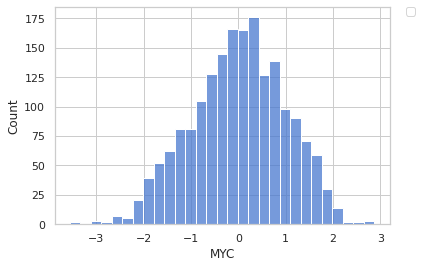

In [ ]:
sns.set(style="whitegrid", palette="muted")
sns.histplot(data=y, x=y)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [ ]:
model = LinearRegression()  
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#the intercept:
print(model.intercept_)
#the slope:
print(model.coef_)

0.016527244951426795
[-0.01580307 -0.01583368  0.01456377 ...  0.00375738 -0.00092929
  0.00283816]


## Predicition

In [ ]:
y_pred = model.predict(X_test)
pred = pd.DataFrame({'True_value': y_test, 'Predicted': y_pred})
pred

,True_value,Predicted
2086,1.548909,1.391276
330,0.184345,-0.075141
1748,0.283792,0.216729
85,1.783478,2.017603
1788,1.341008,2.155868
...,...,...
1539,-0.159662,-0.279690
1863,-1.224326,-0.923696
2045,0.795683,1.427625
181,-0.430577,-0.999291


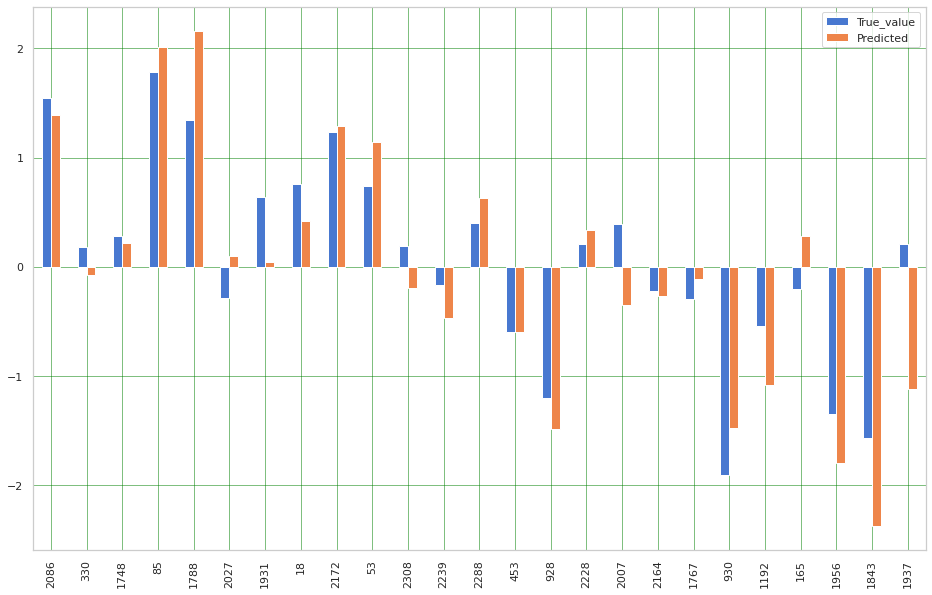

In [ ]:
#plotting the prediction
pred1 = pred.head(25)
pred1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## evaluation

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('coefficient of determination:', model.score(X_test, y_test))

Mean Absolute Error: 0.4704264389884308
Mean Squared Error: 0.3789539843210547
Root Mean Squared Error: 0.6155923848790323
coefficient of determination: 0.6254169703405928


### AIC and BIC

In [ ]:
from math import log
model = LinearRegression()
model.fit(X_train, y_train)
# number of parameters
num_params = len(model.coef_) + 1
print('Number of parameters: %d' % (num_params))
# predict the training set
yhat = model.predict(X_train)
# calculate the error
mse = metrics.mean_squared_error(y_train, yhat)
# calculate aic for regression
def calculate_aic(n, mse, num_params):
	aic = n * log(mse) + 2 * num_params
	return aic
# calculate the aic
aic = calculate_aic(len(y_train), mse, num_params)
print('AIC: %.3f' % aic)
# calculate bic for regression
def calculate_bic(n, mse, num_params):
	bic = n * log(mse) + num_params * log(n)
	return bic
# calculate the bic
bic = calculate_bic(len(y_train), mse, num_params)
print('BIC: %.3f' % bic)

Number of parameters: 4252
AIC: -90650.555
BIC: -68058.742


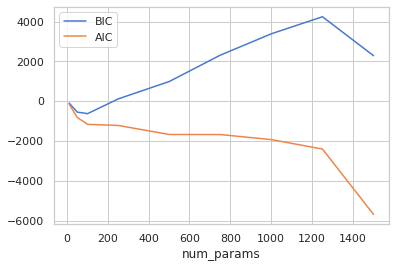

In [ ]:
from sklearn.linear_model import Lasso
features = [10, 50, 75, 100, 250, 500, 750, 1000, 1250, 1500]
AIC = []
BIC = []
par = []

for f in features:
  m = LinearRegression().fit(X_train.iloc[:, 0:f], y_train)
  num_params = len(m.coef_) + 1
  yhat = m.predict(X_train.iloc[:, 0:f])
  mse = metrics.mean_squared_error(y_train, yhat)
  aic = calculate_aic(len(y_train), mse, num_params)
  bic = calculate_bic(len(y_train), mse, num_params)
  AIC.append(aic)
  BIC.append(bic)
  par.append(num_params)

#the plot
plt.plot(par, BIC, label='BIC')
plt.plot(par, AIC, label='AIC')
plt.legend(loc='best')
plt.xlabel('num_params');

## inspection




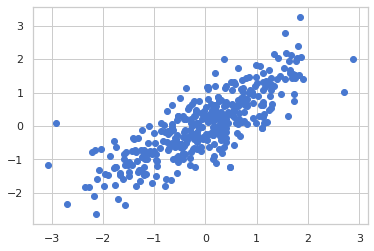

In [ ]:
x_plot = plt.scatter(y_test, y_pred, c='b')

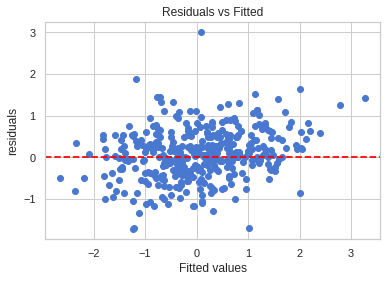

In [ ]:
x_plot = plt.scatter( y_pred, (y_pred - y_test), c='b')
plt.style.use('seaborn')
plt.xlabel('Fitted values')
plt.ylabel('residuals')
plt.title('Residuals vs Fitted')
plt.axhline(y=0, color='red', linestyle='dashed')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


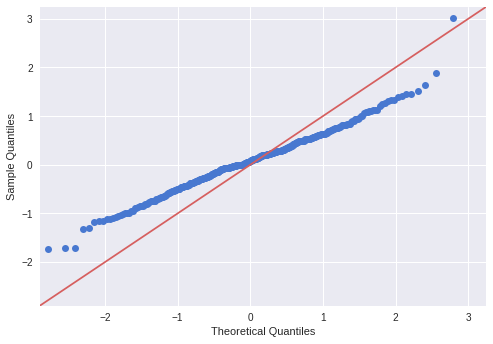

In [ ]:
import statsmodels.api as sm
import pylab

#test = np.random.normal(0,1, 1000)

sm.qqplot((y_pred - y_test), line='45')
pylab.show()

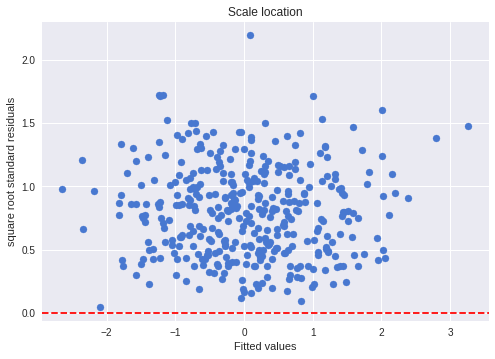

In [ ]:
residuals =(y_pred - y_test)
mean = np.mean(residuals)
std = np.std(residuals)
StdResidual =(residuals -mean)/std
SqrtrStdResidual = np.sqrt(np.absolute(StdResidual))
x_plot = plt.scatter( y_pred, SqrtrStdResidual, c='b')
plt.style.use('seaborn')
plt.xlabel('Fitted values')
plt.ylabel('square root standard residuals')
plt.title('Scale location')
plt.axhline(y=0, color='red', linestyle='dashed')


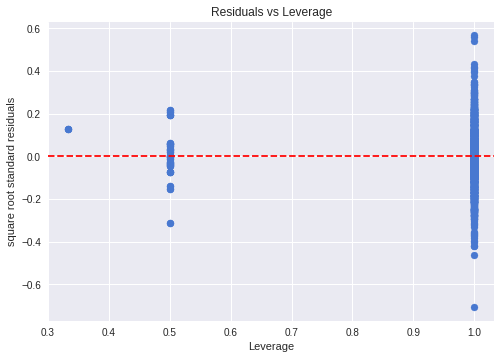

In [ ]:
import statsmodels.api as sm
#fit the model
mod = sm.OLS(y_train, X_train).fit()
res = pd.DataFrame()
res['resid_std'] = mod.resid_pearson
influence = mod.get_influence()
res['leverage'] = influence.hat_matrix_diag
#the plot
x_plot = plt.scatter( res['leverage'], res['resid_std'], c='b')
plt.style.use('seaborn')
plt.xlabel('Leverage')
plt.ylabel('square root standard residuals')
plt.title('Residuals vs Leverage')
plt.axhline(y=0, color='red', linestyle='dashed')

In [ ]:
#mod.summary()

In [ ]:
# Import library 
from statsmodels.stats.outliers_influence import variance_inflation_factor

#VIF calculation for whole dataset
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
#for our dataset
X_short = X_train.iloc[:, 100:200] #we take a subset
vif = calc_vif(X_short)
vif

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,ANXA5,2.646600
1,PSMB7,6.031730
2,PEA15,3.325247
3,ODC1,4.195950
4,IQGAP1,5.901233
...,...,...
95,EIF1AX,3.501304
96,YWHAH,2.947151
97,DSTN,4.996534
98,TAF7,2.840894


In [ ]:
vif_drop = vif[vif.VIF > 5]
names = vif_drop.variables.tolist()
X_short.drop(names, axis=1, inplace=True)
X_short.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(1500, 41)

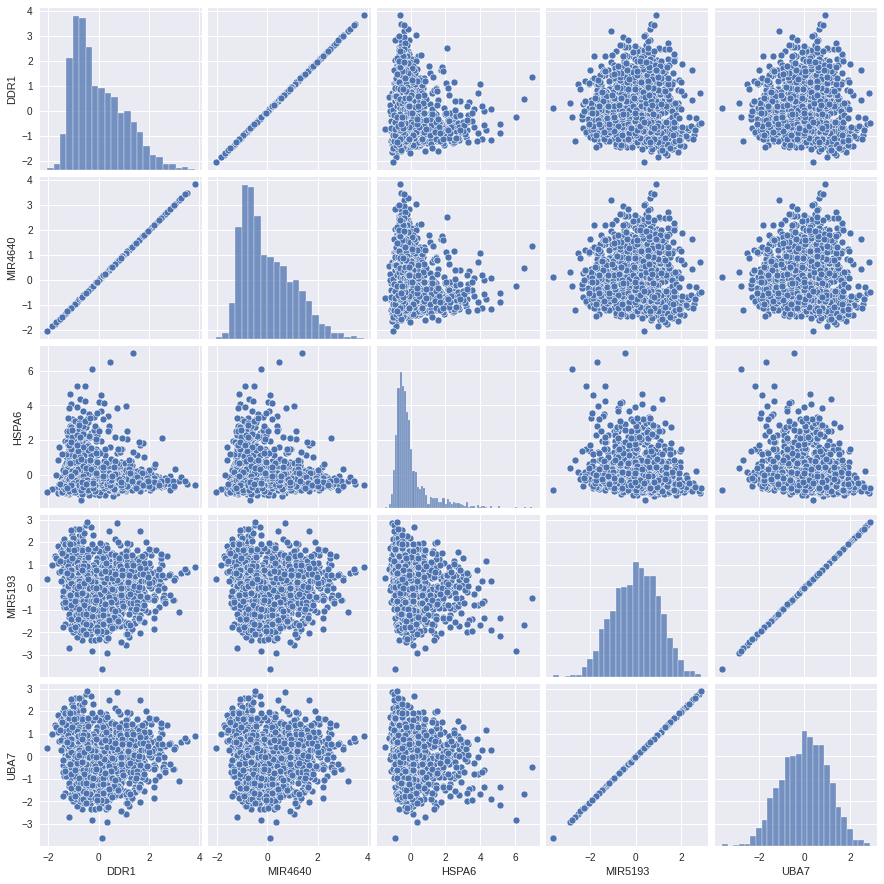

In [ ]:
X_short = X_train.iloc[:, 0:5]
sns.pairplot(X_short)

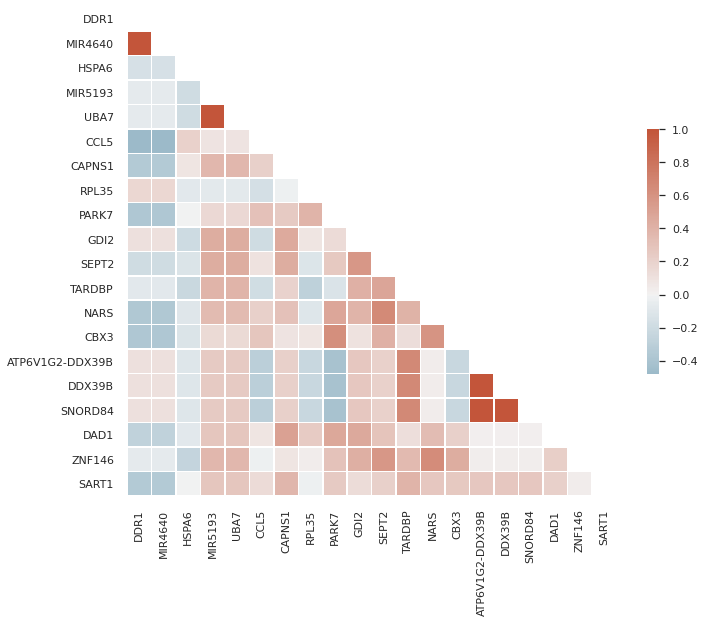

In [ ]:
# Compute the correlation matrix
X_short = X_train.iloc[:, 0:20]
sns.set_theme(style="white")
corr = X_short.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
!apt update
!apt-get install yellowbrick
!pip3 install yellowbrick
!pip install -U yellowbrick

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


AttributeError: ignored

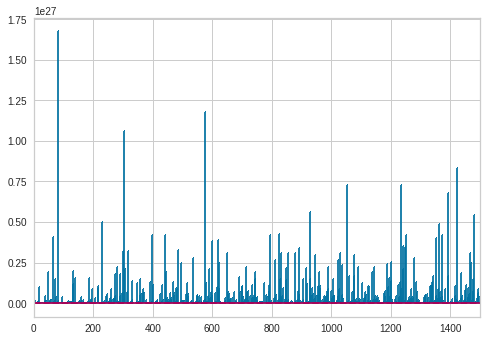

In [ ]:
from yellowbrick.regressor import CooksDistance
# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X_train, y_train)
visualizer.show()

In [ ]:
from sklearn.linear_model import Ridge
model = Ridge(alpha = 0.05)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('coefficient of determination:', model.score(X_test, y_test))

Mean Absolute Error: 0.4703654543902795
Mean Squared Error: 0.3788655475813478
Root Mean Squared Error: 0.6155205500885798
coefficient of determination: 0.6255043870277455


In [ ]:
from sklearn.linear_model import Lasso
model = Lasso(alpha = 0.05)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('coefficient of determination:', model.score(X_test, y_test))

Mean Absolute Error: 0.5173210873767923
Mean Squared Error: 0.4378847678030309
Root Mean Squared Error: 0.6617286209640859
coefficient of determination: 0.5671659099739088


In [ ]:
coefs = model.coef_.flatten()
names = X_train.columns
genes = list(zip(names, coefs))
feature =pd.DataFrame(genes, columns = ["genes", "coefs"])

In [ ]:
#feature0 = feature.drop[~(feature==0).all(axis=1)]
#feature0 = feature.drop(feature[feature == 0].index, axis=1)
feature0 = feature.loc[(feature!=0).any(axis=1)]
feature0 = feature[(feature != 0).all(1)]
feature0.shape, feature.shape


((77, 2), (4251, 2))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]),
 <a list of 77 Text major ticklabel objects>)

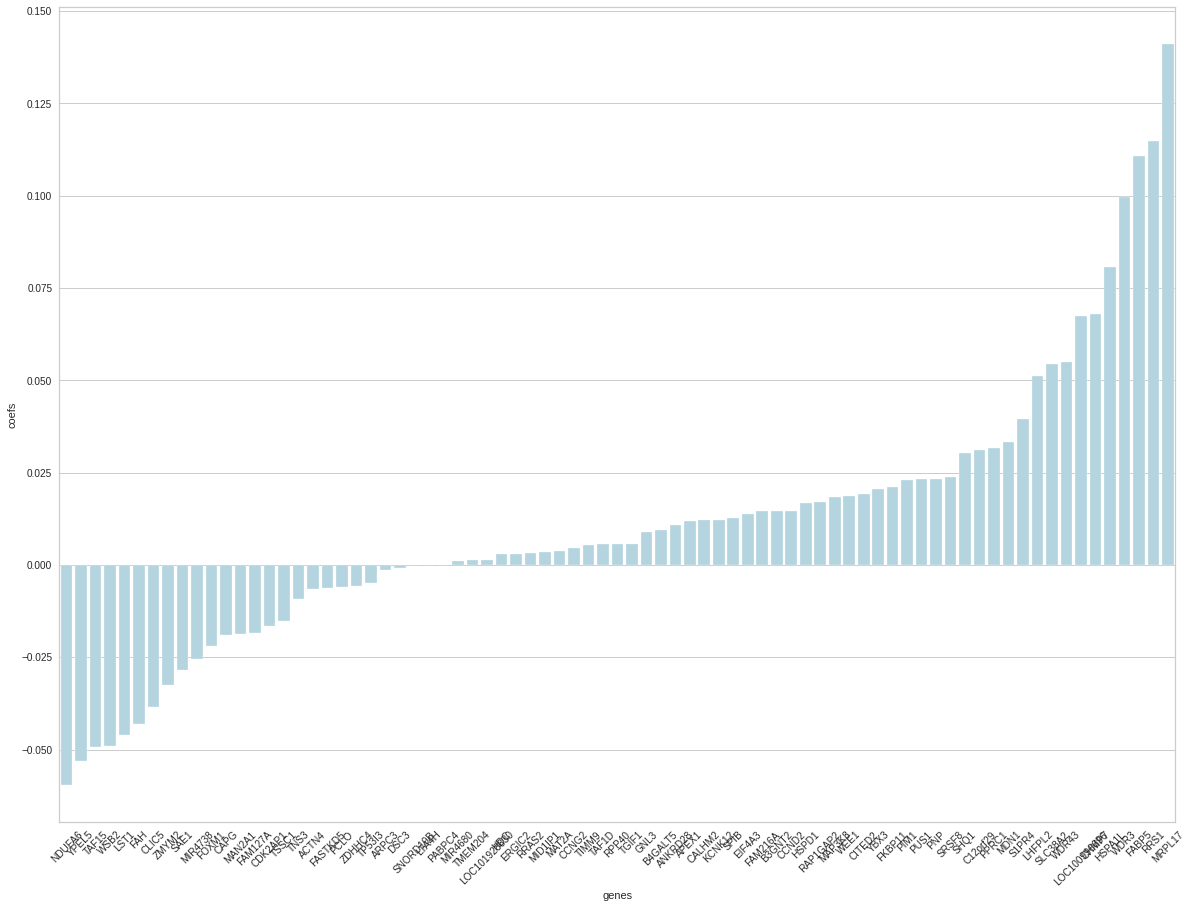

In [ ]:
coefs =feature0.sort_values(by=['coefs'])
plt.figure(figsize=(20, 15))
g = sns.barplot(x="genes", y="coefs", data=coefs, color= "lightblue")
g.figsize=(16,10)
plt.xticks(rotation=45)

In [ ]:
y = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
for i in y:
    model = Lasso(alpha = i, max_iter = 10000)
    model.fit(X_train, y_train)
    coefs = model.coef_.flatten()
    names = X_train.columns
    genes = list(zip(names, coefs))
    x = "coef" + "_lr1_" + str(i)
    feature1 =pd.DataFrame(genes, columns = ["genes", x])
    feature = pd.merge(feature, feature1,  left_on='genes',right_on='genes',how='outer')
    feature0 = feature1[(feature1 != 0).all(1)]
    print(model.alpha), print(feature0.shape)
    print('coefficient of determination:', model.score(X_test, y_test))



0.5
(1, 2)
coefficient of determination: 0.042236310184953774
0.1
(29, 2)
coefficient of determination: 0.453784687270934
0.05
(77, 2)
coefficient of determination: 0.5671659099739088
0.01
(410, 2)
coefficient of determination: 0.7245714046754731
0.005
(665, 2)
coefficient of determination: 0.7151390800499817
0.001
(1258, 2)
coefficient of determination: 0.625008906348056


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8421982815776357, tolerance: 0.1494806424264493
  positive)


In [ ]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=0.5, l1_ratio=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('coefficient of determination:', model.score(X_test, y_test))

Mean Absolute Error: 0.6858106490453862
Mean Squared Error: 0.7506277063875101
Root Mean Squared Error: 0.8663877344396734
coefficient of determination: 0.258030230481196


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from numpy import absolute
X = df.drop("MYC", 1)
y = df["MYC"]
# define model
model = ElasticNet(alpha=0.5, l1_ratio=0.5)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
np.mean(scores), np.std(scores)

(0.6848243714533871, 0.026644416266827634)

In [ ]:
np.mean(scores), np.std(scores)

(0.7952184133444551, 0.05051209012800685)

In [ ]:
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
# define model
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X.iloc[:, 0:100], y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.538
Config: {'alpha': 0.01, 'l1_ratio': 0.03}


In [ ]:
arange(0, 1, 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [ ]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=0.01, l1_ratio=0.03)
model.fit(X_train.iloc[:, 0:100], y_train)
y_pred = model.predict(X_test.iloc[:, 0:100])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('coefficient of determination:', model.score(X_test.iloc[:, 0:100], y_test))

Mean Absolute Error: 0.5836502695639036
Mean Squared Error: 0.5617756882353885
Root Mean Squared Error: 0.7495169699449029
coefficient of determination: 0.4447039799166488


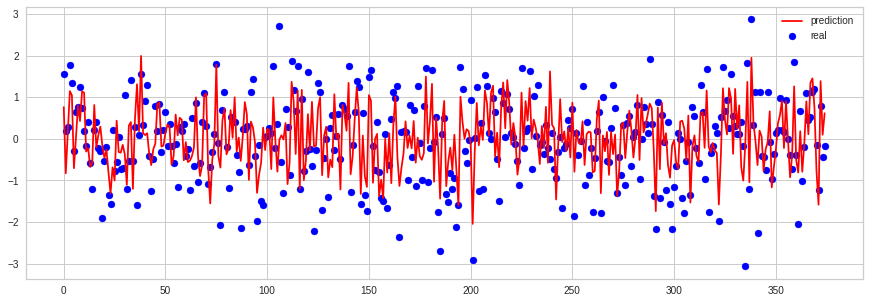

In [ ]:
x_ax = range(len(X_test))
plt.figure(figsize=(15, 5))
plt.scatter(x_ax, y_test, color = "blue", label ="real")
plt.plot(x_ax, y_pred, color = "red", label ="prediction")
plt.legend()
plt.show()